In [1]:
import os, sys
base_pathname = os.path.join("/home/jgutman", "mvesc")
sys.path.insert(0, os.path.join(base_pathname, 'ETL'))

In [2]:
from mvesc_utility_functions import *
import pandas as pd
import numpy as np
import re
import pickle

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = os.path.join(base_pathname, 'Error_Feature_Analysis', 'pkls')
filename = 'selected_RF_not_on_time.pkl'
load_pkl = True

In [10]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
def get_specific_cross_tabs(crosstabs, key, feature):
    """
    Given the dictionary of all possible crosstabs, and a filename for a
    single model, and a single feature, and whether to use the predictions on
    train/val/test set, returns a nicely formatted crosstab dataframe for that
    model/feature/set.

    :param dict(tuple: list(dataframe)) crosstabs: the full crosstabs dictionary
        as computed by loop_through_top_models function
    :param str model_name: a string containing the model type for the
        specific model run to pull crosstabs for
    :param str label: a string containing the outcome label to pull
    :param str feature: a string containing the feature e.g. 'days_present_gr_9'
    :param str split: whether to pull predictions on train, val, or test
    :returns dataframe containing actual vs predicted vs marginal proportions
        on positive/negative class by binned level of feature
    :rtype pd.dataframe
    """
    crosstab = crosstabs[key][feature]
    totals = crosstab.ix['true_label: All']
    predicted = 100*crosstab.ix[['predicted_label: True',
        'predicted_label: False']]/totals
    actual = 100*crosstab.ix[['true_label: True',
        'true_label: False']]/totals
    full = predicted.append(actual)
    full = full.append(totals*100)
    full = full.round(2)
    return full

def build_temp_table_best_models(cursor, optimization_criteria,
    table_name = 'top_models', feature_categories = 'all',
    prediction_grade = 10, timestamp_filter = '2016-08-09 06:00:00'):
    """
    For each model_name and label category, filtered on specified options
    grab the highest ranking model according to the optimization criteria.
    Return a list of tuples containing the filename, model_name, label,
    feature list, and grade range for the models you want to pull predictions

    :param pscyopg2.cursor cursor: a cursor to execute queries on the database
    :param str table_name: name for the temporary table to hold best models
    :param str feature_categories: specify what features are given to the models
        being compared, by default include only models trained on all features
    :param int prediction_grade: the prediction time point for all models
    :param str timestamp_filter: a timestamp format string to ignore all models
        run prior to the time specified here

    :returns a list of the top models to compare features for
        each model specified as (filename, model_name, label, features, grades)
    :rtype list(tuple)
    """
    if (feature_categories == 'all'):
        feature_categories = '%,%,%'
    top_models_query = """
    drop table if exists {table};
    create temporary table {table} as
    select distinct on (model_name, label) * from
        (select model_name, filename, label, feature_categories,
        feature_grades, {criteria},
        rank() over (partition by (model_name, label)
        order by {ranker} desc) as val_rank
        from model.reports
        where debug=false
        and feature_categories like '{features}'
        and cv_scheme = 'leave_cohort_out'
        and prediction_grade = {grade}
        and timestamp > '{timestamp}'
        order by model_name, label, val_rank) vr
    order by model_name, label, val_rank;
    """.format(table = table_name, features = feature_categories,
        grade = prediction_grade, timestamp = timestamp_filter,
        criteria = ", ".join(optimization_criteria),
        ranker = optimization_criteria[0])

    cursor.execute(top_models_query)
    cursor.execute("""select filename, model_name, label,
        feature_categories, feature_grades from {table}
        """.format(table=table_name))
    models_and_features = cursor.fetchall()

    print('done grabbing models')
    return models_and_features

def loop_through_top_models(cursor, models_and_features,
    splits = ['train', 'val', 'test']):
    """
    Get a list of models to search over and then for each model, pull the
    predictions and feature values for every student in the specified splits
    for all features included in the feature categories and grade range of the
    model. Then bin those features into categorical variables and build rough
    crosstabs on each model-feature-split combination.

    :param list(str) optimization_criteria: a list of model selection criteria
        to compare models, with the first element used to pull the top model
    :param list(str) splits: a list of what sets should be included, i.e. some
        combination of 'train', 'test', 'val'
    :returns a dictionary of rough crosstabs, keyed by model
    """
    crosstabs_by_model_and_feature = dict()

    for (table_name, model_name, label, feature_tables,
            feature_grade_range) in models_and_features:
        print('working on {}:{}'.format(model_name, label))
        feature_table_list = feature_tables.split(", ")
        feature_grades = [int(i) for i in
                feature_grade_range.split(", ")]
        feature_grade_regex = '({})'.format('|'.join(
            [str(i) for i in feature_grades]))
        pattern = re.compile('(_gr_{rx}\Z)|(\D\Z)'.format(
            rx=feature_grade_regex))

        for test_set in splits:
            get_model_predictions = """
            select * from
            (select student_lookup, true_label, predicted_label,
            predicted_label = true_label as correct
            from predictions."{table}"
            where split = '{test_set}') preds
            """.format(table = table_name, test_set = test_set)

            for features in feature_table_list:
                get_model_predictions += """ left join
            (select * from model.{features}) {features}
            using(student_lookup)
            """.format(features = features)

            cursor.execute(get_model_predictions)
            predictions_and_features = cursor.fetchall()
            colnames = [i[0] for i in cursor.description]

            predictions = pd.DataFrame.from_records(
                predictions_and_features,
                index = 'student_lookup',
                columns = colnames)
            predictions = predictions.filter(regex=pattern)
            predictions[['true_label', 'predicted_label']] = \
            predictions[['true_label', 'predicted_label']].astype(bool)
            predictions = make_df_categorical(predictions)

            crosstabs = build_crosstabs(predictions)
            key = (table_name, model_name, label, test_set)
            crosstabs_by_model_and_feature[key] = crosstabs
    return crosstabs_by_model_and_feature

def build_crosstabs(prediction_data):
    predicted = {col: pd.crosstab(index=prediction_data.predicted_label,
                    columns = prediction_data[col], margins=True,
                    normalize = True)
                for col in prediction_data.columns[3:]}
    actual = {col: pd.crosstab(index=prediction_data.true_label,
                    columns = prediction_data[col], margins=True,
                    normalize = True)
                 for col in prediction_data.columns[3:]}
    correct = {col: pd.crosstab(index=prediction_data.correct,
                    columns = prediction_data[col], margins=True,
                    normalize = True)
                 for col in prediction_data.columns[3:]}

    predicted_plus_actual = dict()
    for feature in predicted.keys():
        preds = predicted[feature]
        true = actual[feature]
        corr = correct[feature]
        preds.index = ['{name}: {value}'.format(name=preds.index.name,
                        value=value) for value in preds.index]
        true.index = ['{name}: {value}'.format(name=true.index.name,
                        value=value) for value in true.index]
        corr.index = ['{name}: {value}'.format(name=corr.index.name,
                        value=value) for value in corr.index]
        full = preds.append(true)
        full = full.append(corr)
        predicted_plus_actual[feature] = full
    return predicted_plus_actual

def make_df_categorical(raw_data):
    string_features = raw_data.select_dtypes(include=[object, bool])
    numeric_features = raw_data.select_dtypes(include=[np.number])

    for string_col in string_features.columns:
        raw_data[string_col] = string_features[string_col].astype('category')
        if (len(raw_data[string_col].cat.categories) < 2
            and string_col != 'predicted_label'
            and string_col != 'true_label'
            and string_col != 'correct'):
            raw_data.drop(string_col, axis=1, inplace=True)

    for numeric_col in numeric_features.columns:
        num_values = len(numeric_features[numeric_col].unique())
        num_bins = min(5, num_values)
        if (num_values < 2):
            raw_data.drop(numeric_col, axis=1, inplace=True)
        elif (num_values == 2 and
            numeric_features[numeric_col].isnull().sum() > 0):
            raw_data[numeric_col] = numeric_features[numeric_col] \
                .isnull().astype('category')
        else:
            raw_data[numeric_col] = pd.cut(numeric_features[numeric_col],
                bins = num_bins, precision = 1)
    return raw_data

In [5]:
if load_pkl:
    # load pkl file
    pkl_file = open(os.path.join(path, filename),'rb')
    all_top_crosstabs = pickle.load(pkl_file)

else:
    with postgres_pgconnection_generator() as connection:
        with connection.cursor() as cursor:
            models_and_features = build_temp_table_best_models(
                cursor, optimization_criteria)
            """
            select_hanna_models = "
                select distinct on (filename) filename, model_name, label,
                feature_categories, feature_grades
                from model.reports
                where filename in 
                ('08_09_2016_grade_6_param_set_0_RF_ht_8585',
                '08_09_2016_grade_7_param_set_7_RF_ht_10497',
                '08_09_2016_grade_8_param_set_13_RF_ht_13254',
                '08_09_2016_grade_9_param_set_0_RF_ht_8645',
                '08_09_2016_grade_10_param_set_0_RF_ht_8680');"
            cursor.execute(select_hanna_models)
            models_and_features = cursor.fetchall()
            """
            all_top_crosstabs = loop_through_top_models(
                cursor, models_and_features, ['val', 'test'])
            with open(os.path.join(path, filename), 'wb') as f:
                pickle.dump(all_top_crosstabs, f)

In [6]:
len(all_top_crosstabs.keys())

10

In [7]:
# models and features to display crosstabs for
ignore_splits = set('train')
ignore_models = set()
ignore_outcomes = set()
specific_feature_list = dict()
specific_feature_list = {'08_09_2016_grade_10_param_set_0_RF_ht_8680':
    ['gpa_district_gr_9', 'absence_gr_9', 'gpa_gr_9', 'humanities_gpa_gr_9',
    'eighth_math_percentile', 'health_gpa_gr_9', 'eighth_math_normalized',
    'eighth_read_normalized', 'stem_gpa_gr_9', 'seventh_math_normalized'],
'08_09_2016_grade_6_param_set_0_RF_ht_8585': ['sixth_math_percentile',
    'eighth_math_normalized', 'sixth_math_normalized',
    'eighth_math_percentile', 'fifth_socstudies_normalized',
    'eighth_science_normalized', 'eighth_science_percentile',
    'absence_gr_5', 'sixth_read_normalized', 'seventh_read_percentile'],
'08_09_2016_grade_7_param_set_7_RF_ht_10497': ['eighth_math_percentile',
    'eighth_math_normalized', 'sixth_math_percentile',
    'sixth_math_normalized', 'eighth_read_normalized', 'gpa_district_gr_6',
    'absence_gr_6', 'fifth_socstudies_normalized',
    'eighth_science_normalized', 'seventh_read_normalized'],
'08_09_2016_grade_8_param_set_13_RF_ht_13254': ['gpa_gr_7',
    'gpa_district_gr_7', 'stem_gpa_gr_7', 'humanities_gpa_gr_7',
    'eighth_math_percentile', 'absence_gr_7', 'eighth_math_normalized',
    'eighth_science_normalized', 'eighth_science_percentile',
    'sixth_math_percentile'],
'08_09_2016_grade_9_param_set_0_RF_ht_8645': ['gpa_gr_8',
    'gpa_district_gr_8', 'absence_gr_8', 'eighth_math_percentile',
    'stem_gpa_gr_8', 'eighth_math_normalized', 'humanities_gpa_gr_8',
    'eighth_science_normalized', 'seventh_read_normalized',
    'eighth_read_normalized']}

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time val


eighth_math_percentile,"(0.002, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,21.28,4.33,0.44,1.54,0.44,5.15
predicted_label: False,78.72,95.67,99.56,98.46,99.56,94.85
true_label: True,36.17,23.81,11.50,13.33,10.57,18.65
true_label: False,63.83,76.19,88.50,86.67,89.43,81.35
true_label: All,17.62,21.65,21.18,18.28,21.27,100.00


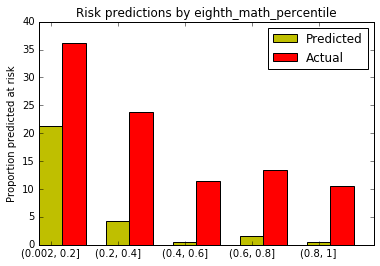

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time val


eighth_math_normalized,"(-2.5, -1.4]","(-1.4, -0.3]","(-0.3, 0.8]","(0.8, 1.9]","(1.9, 3.0006]",All
predicted_label: True,30.88,8.26,0.95,0.50,0.00,5.15
predicted_label: False,69.12,91.74,99.05,99.50,100.00,94.85
true_label: True,50.00,25.36,12.35,11.50,3.70,18.65
true_label: False,50.00,74.64,87.65,88.50,96.30,81.35
true_label: All,6.37,32.90,39.46,18.74,2.53,100.00


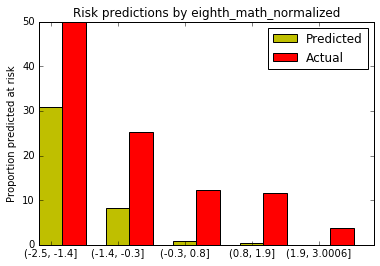

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time val


sixth_math_percentile,"(0.003, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,29.52,3.74,0.45,0.95,0.00,5.69
predicted_label: False,70.48,96.26,99.55,99.05,100.00,94.31
true_label: True,39.76,22.99,19.82,11.43,6.75,18.71
true_label: False,60.24,77.01,80.18,88.57,93.25,81.29
true_label: All,16.01,18.03,21.41,20.25,24.30,100.00


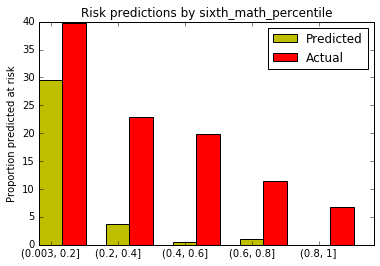

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time val


sixth_math_normalized,"(-2.9, -1.6]","(-1.6, -0.3]","(-0.3, 1]","(1, 2.2]","(2.2, 3.5]",All
predicted_label: True,42.86,15.36,0.74,0.00,0.00,5.69
predicted_label: False,57.14,84.64,99.26,100.00,100.00,94.31
true_label: True,35.71,32.50,14.71,7.19,5.56,18.71
true_label: False,64.29,67.50,85.29,92.81,94.44,81.29
true_label: All,2.70,27.00,52.46,16.10,1.74,100.00


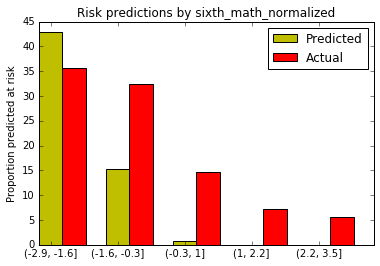

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time val


eighth_read_normalized,"(-3.1, -1.8]","(-1.8, -0.5]","(-0.5, 0.9]","(0.9, 2.2]","(2.2, 3.5]",All
predicted_label: True,53.57,12.64,0.96,0.47,0.00,5.15
predicted_label: False,46.43,87.36,99.04,99.53,100.00,94.85
true_label: True,53.57,33.46,13.60,10.28,2.86,18.63
true_label: False,46.43,66.54,86.40,89.72,97.14,81.37
true_label: All,2.62,25.19,48.88,20.04,3.28,100.00


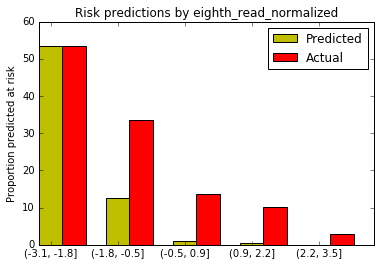

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time val


gpa_district_gr_6,"(-2.6, -1.8]","(-1.8, -1]","(-1, -0.1]","(-0.1, 0.7]","(0.7, 1.5]",All
predicted_label: True,83.33,30.95,8.72,2.61,1.97,6.98
predicted_label: False,16.67,69.05,91.28,97.39,98.03,93.02
true_label: True,50.00,54.76,22.67,12.17,13.82,18.94
true_label: False,50.00,45.24,77.33,87.83,86.18,81.06
true_label: All,1.00,6.98,28.57,38.21,25.25,100.00


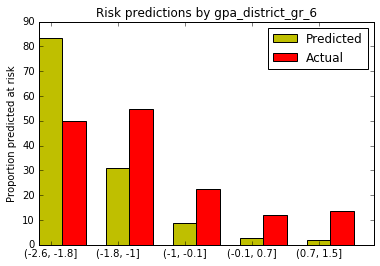

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time val


absence_gr_6,"(-0.08, 15.3]","(15.3, 30.6]","(30.6, 45.9]","(45.9, 61.2]","(61.2, 76.5]",All
predicted_label: True,5.63,15.62,0.00,0.00,0.00,6.46
predicted_label: False,94.37,84.37,100.00,100.00,100.00,93.54
true_label: True,19.25,31.25,66.67,100.00,0.00,20.47
true_label: False,80.75,68.75,33.33,0.00,100.00,79.53
true_label: All,90.93,8.62,0.27,0.09,0.09,100.00


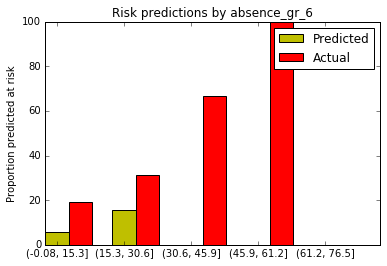

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time val


fifth_socstudies_normalized,"(-3.2, -1.9]","(-1.9, -0.6]","(-0.6, 0.7]","(0.7, 2]","(2, 3.3]",All
predicted_label: True,35.29,17.43,0.99,0.00,0.00,4.85
predicted_label: False,64.71,82.57,99.01,100.00,100.00,95.15
true_label: True,29.41,29.36,18.06,7.60,4.76,17.82
true_label: False,70.59,70.64,81.94,92.40,95.24,82.18
true_label: All,1.68,21.58,49.90,24.75,2.08,100.00


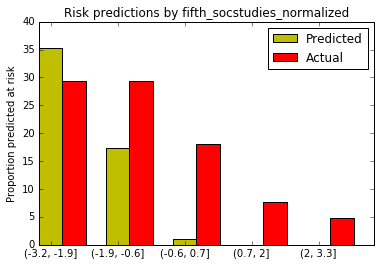

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time val


eighth_science_normalized,"(-2.6, -1.2]","(-1.2, 0.1]","(0.1, 1.5]","(1.5, 2.8]","(2.8, 4.1]",All
predicted_label: True,30.77,6.26,0.64,0.00,0.00,5.15
predicted_label: False,69.23,93.74,99.36,100.00,100.00,94.85
true_label: True,42.31,24.38,10.52,11.59,0.00,18.65
true_label: False,57.69,75.62,89.48,88.41,100.00,81.35
true_label: All,7.31,41.89,43.67,6.47,0.66,100.00


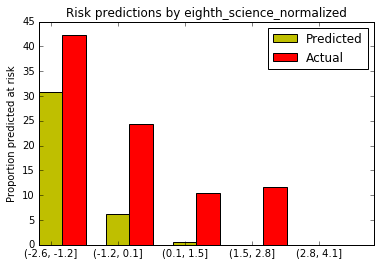

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time val


seventh_read_normalized,"(-3.4, -2.1]","(-2.1, -0.9]","(-0.9, 0.4]","(0.4, 1.7]","(1.7, 2.9]",All
predicted_label: True,57.14,20.71,3.20,0.49,0.00,5.48
predicted_label: False,42.86,79.29,96.80,99.51,100.00,94.52
true_label: True,35.71,37.28,19.18,11.85,12.00,19.14
true_label: False,64.29,62.72,80.82,88.15,88.00,80.86
true_label: All,1.30,15.71,40.71,37.64,4.65,100.00


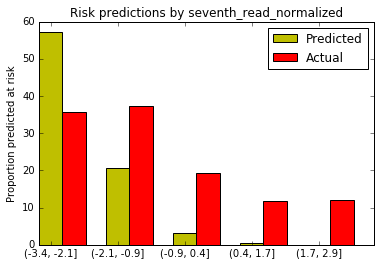

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time test


eighth_math_percentile,"(0.0003, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,26.05,5.18,0.69,0.76,0.43,5.92
predicted_label: False,73.95,94.82,99.31,99.24,99.57,94.08
true_label: True,42.79,26.29,17.01,8.75,3.86,19.12
true_label: False,57.21,73.71,82.99,91.25,96.14,80.88
true_label: All,17.20,20.08,23.04,21.04,18.64,100.00


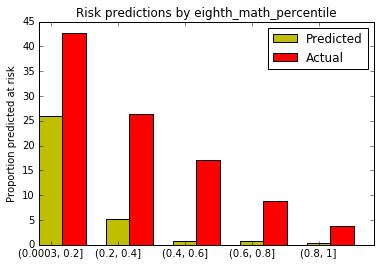

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time test


eighth_math_normalized,"(-3.008, -1.6]","(-1.6, -0.2]","(-0.2, 1.2]","(1.2, 2.6]","(2.6, 4]",All
predicted_label: True,43.75,11.48,0.77,0.0,0.00,5.92
predicted_label: False,56.25,88.52,99.23,100.0,100.00,94.08
true_label: True,41.67,33.01,11.83,3.2,0.00,19.12
true_label: False,58.33,66.99,88.17,96.8,100.00,80.88
true_label: All,3.84,33.44,52.08,10.0,0.64,100.00


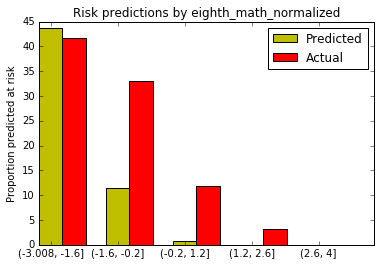

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time test


sixth_math_percentile,"(-1, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,27.14,3.11,0.78,0.42,0.00,5.53
predicted_label: False,72.86,96.89,99.22,99.58,100.00,94.47
true_label: True,41.90,28.00,16.73,13.45,4.63,19.74
true_label: False,58.10,72.00,83.27,86.55,95.37,80.26
true_label: All,17.34,18.58,21.22,19.65,23.20,100.00


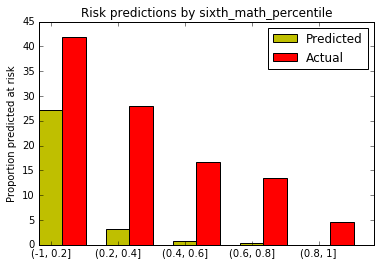

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time test


sixth_math_normalized,"(-2.9, -1.6]","(-1.6, -0.3]","(-0.3, 0.9]","(0.9, 2.2]","(2.2, 3.5]",All
predicted_label: True,60.38,9.25,0.52,0.00,0.00,5.53
predicted_label: False,39.62,90.75,99.48,100.00,100.00,94.47
true_label: True,50.94,33.82,15.03,2.87,9.68,19.74
true_label: False,49.06,66.18,84.97,97.13,90.32,80.26
true_label: All,4.38,28.57,47.23,17.26,2.56,100.00


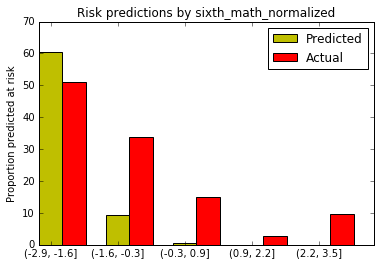

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time test


eighth_read_normalized,"(-3.0009, -1.8]","(-1.8, -0.7]","(-0.7, 0.5]","(0.5, 1.7]","(1.7, 2.8]",All
predicted_label: True,38.0,19.25,2.33,0.28,0.0,5.92
predicted_label: False,62.0,80.75,97.67,99.72,100.0,94.08
true_label: True,46.0,40.85,17.92,7.34,4.0,19.12
true_label: False,54.0,59.15,82.08,92.66,96.0,80.88
true_label: All,4.0,17.04,44.64,28.32,6.0,100.00


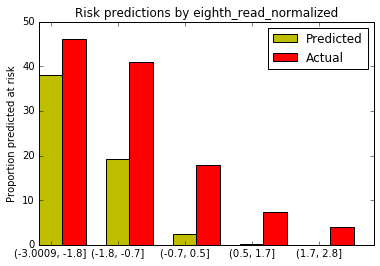

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time test


gpa_district_gr_6,"(-1.8, -1.1]","(-1.1, -0.5]","(-0.5, 0.2]","(0.2, 0.9]","(0.9, 1.5]",All
predicted_label: True,47.22,17.72,1.92,0.00,3.01,6.27
predicted_label: False,52.78,82.28,98.08,100.00,96.99,93.73
true_label: True,36.11,48.10,29.49,10.40,3.01,20.13
true_label: False,63.89,51.90,70.51,89.60,96.99,79.87
true_label: All,5.94,13.04,25.74,33.33,21.95,100.00


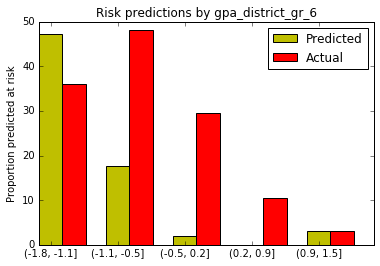

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time test


absence_gr_6,"(-0.05, 10.5]","(10.5, 21]","(21, 31.5]","(31.5, 42]","(42, 52.5]",All
predicted_label: True,5.95,9.09,10.34,28.57,0.00,6.69
predicted_label: False,94.05,90.91,89.66,71.43,100.00,93.31
true_label: True,18.23,27.27,41.38,28.57,0.00,20.31
true_label: False,81.77,72.73,58.62,71.43,100.00,79.69
true_label: All,80.15,16.92,2.23,0.54,0.15,100.00


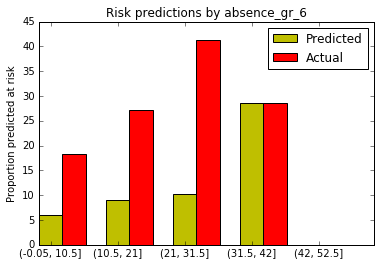

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time test


fifth_socstudies_normalized,"(-2.8, -1.3]","(-1.3, 0.2]","(0.2, 1.7]","(1.7, 3.2]","(3.2, 4.7]",All
predicted_label: True,35.16,6.51,0.19,0.00,0.00,5.53
predicted_label: False,64.84,93.49,99.81,100.00,100.00,94.47
true_label: True,42.86,28.21,9.35,5.80,0.00,19.70
true_label: False,57.14,71.79,90.65,94.20,100.00,80.30
true_label: All,7.63,42.50,43.92,5.78,0.17,100.00


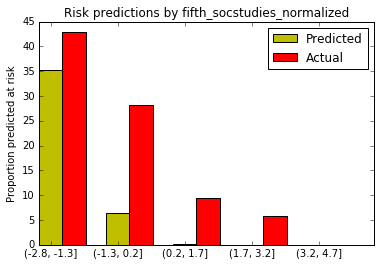

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time test


eighth_science_normalized,"(-3.01, -1.7]","(-1.7, -0.4]","(-0.4, 0.9]","(0.9, 2.2]","(2.2, 3.4]",All
predicted_label: True,47.22,14.20,1.52,0.38,0.00,5.92
predicted_label: False,52.78,85.80,98.48,99.62,100.00,94.08
true_label: True,52.78,36.86,13.30,6.79,4.17,19.12
true_label: False,47.22,63.14,86.70,93.21,95.83,80.88
true_label: All,2.88,26.48,47.52,21.20,1.92,100.00


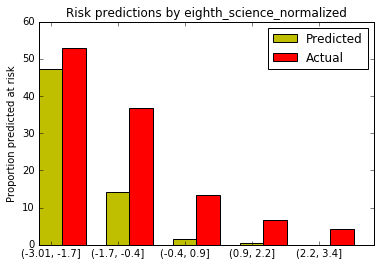

08_09_2016_grade_7_param_set_7_RF_ht_10497 RF not_on_time test


seventh_read_normalized,"(-3, -1.7]","(-1.7, -0.4]","(-0.4, 0.9]","(0.9, 2.2]","(2.2, 3.6]",All
predicted_label: True,43.33,13.64,0.96,0.00,0.00,5.91
predicted_label: False,56.67,86.36,99.04,100.00,100.00,94.09
true_label: True,50.00,37.01,12.32,7.97,0.00,19.23
true_label: False,50.00,62.99,87.68,92.03,100.00,80.77
true_label: All,4.79,24.58,49.88,20.03,0.72,100.00


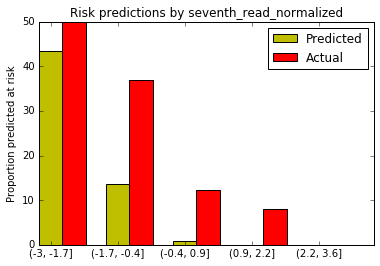

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time val


gpa_district_gr_9,"(-2.6, -1.9]","(-1.9, -1.1]","(-1.1, -0.3]","(-0.3, 0.4]","(0.4, 1.2]",All
predicted_label: True,71.43,16.80,6.41,2.56,1.19,6.55
predicted_label: False,28.57,83.20,93.59,97.44,98.81,93.45
true_label: True,74.29,48.00,21.15,13.29,7.14,18.84
true_label: False,25.71,52.00,78.85,86.71,92.86,81.16
true_label: All,2.83,10.11,25.22,34.68,27.16,100.00


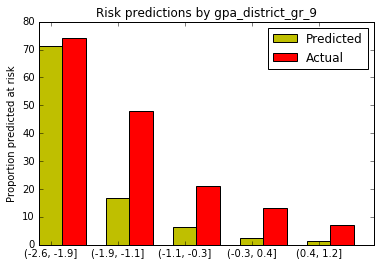

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time val


absence_gr_9,"(-0.1, 22]","(22, 44]","(44, 66]","(66, 88]","(88, 110]",All
predicted_label: True,6.90,27.13,30.77,100.00,50.00,8.25
predicted_label: False,93.10,72.87,69.23,0.00,50.00,91.75
true_label: True,18.27,54.26,53.85,100.00,50.00,20.56
true_label: False,81.73,45.74,46.15,0.00,50.00,79.44
true_label: All,93.67,5.63,0.57,0.04,0.09,100.00


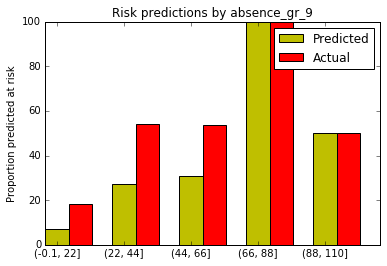

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time val


gpa_gr_9,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,67.74,19.85,5.33,2.72,1.50,6.55
predicted_label: False,32.26,80.15,94.67,97.28,98.50,93.45
true_label: True,77.42,47.33,22.19,12.13,6.91,18.84
true_label: False,22.58,52.67,77.81,87.87,93.09,81.16
true_label: All,2.51,10.59,27.32,32.66,26.92,100.00


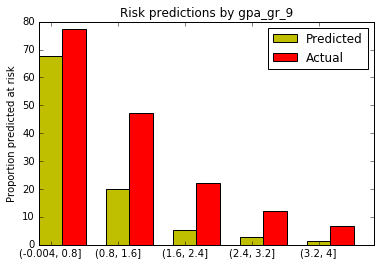

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time val


humanities_gpa_gr_9,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,56.60,13.46,6.02,2.53,1.11,6.58
predicted_label: False,43.40,86.54,93.98,97.47,98.89,93.42
true_label: True,64.15,41.03,20.68,12.15,8.03,18.68
true_label: False,35.85,58.97,79.32,87.85,91.97,81.32
true_label: All,4.31,12.67,21.61,32.09,29.33,100.00


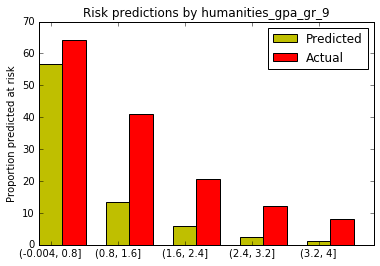

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time val


eighth_math_percentile,"(-0.0006, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,27.79,3.29,0.96,0.52,0.22,5.93
predicted_label: False,72.21,96.71,99.04,99.48,99.78,94.07
true_label: True,35.42,25.00,13.91,10.59,9.03,18.40
true_label: False,64.58,75.00,86.09,89.41,90.97,81.60
true_label: All,17.54,21.80,19.93,18.50,22.23,100.00


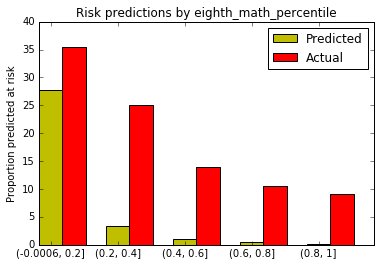

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time val


health_gpa_gr_9,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,40.00,16.26,5.28,4.79,2.05,6.68
predicted_label: False,60.00,83.74,94.72,95.21,97.95,93.32
true_label: True,70.00,34.96,22.64,16.90,6.92,19.02
true_label: False,30.00,65.04,77.36,83.10,93.08,80.98
true_label: All,4.23,10.40,22.40,30.01,32.97,100.00


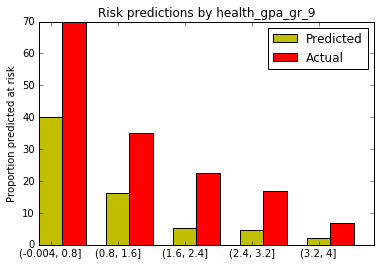

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time val


eighth_math_normalized,"(-3.6, -2.04]","(-2.04, -0.5]","(-0.5, 1.1]","(1.1, 2.7]","(2.7, 4.3]",All
predicted_label: True,41.18,17.01,0.77,0.00,0.00,5.93
predicted_label: False,58.82,82.99,99.23,100.00,100.00,94.07
true_label: True,52.94,32.13,12.45,9.67,16.67,18.40
true_label: False,47.06,67.87,87.55,90.33,83.33,81.60
true_label: All,0.81,30.35,55.69,12.86,0.29,100.00


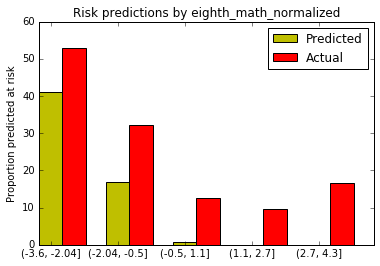

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time val


eighth_read_normalized,"(-3.1, -1.6]","(-1.6, -0.1]","(-0.1, 1.4]","(1.4, 2.8]","(2.8, 4.3]",All
predicted_label: True,45.35,8.96,0.72,0.00,0.00,5.92
predicted_label: False,54.65,91.04,99.28,100.00,100.00,94.08
true_label: True,43.02,26.87,10.86,5.19,0.00,18.39
true_label: False,56.98,73.13,89.14,94.81,100.00,81.61
true_label: All,4.11,41.61,46.63,7.36,0.29,100.00


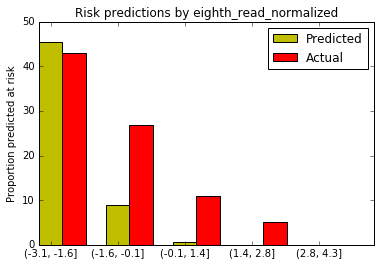

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time val


stem_gpa_gr_9,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,32.94,9.79,6.09,4.98,0.79,7.14
predicted_label: False,67.06,90.21,93.91,95.02,99.21,92.86
true_label: True,58.82,27.97,17.31,16.28,8.33,19.58
true_label: False,41.18,72.03,82.69,83.72,91.67,80.42
true_label: All,7.78,13.08,28.55,27.54,23.06,100.00


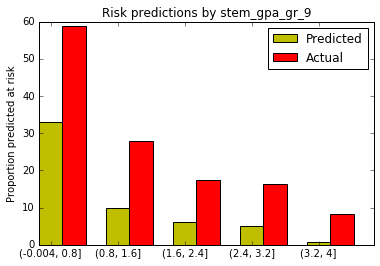

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time val


seventh_math_normalized,"(-3.3, -1.8]","(-1.8, -0.3]","(-0.3, 1.2]","(1.2, 2.6]","(2.6, 4.1]",All
predicted_label: True,38.46,12.20,1.44,0.38,0.00,5.66
predicted_label: False,61.54,87.80,98.56,99.62,100.00,94.34
true_label: True,35.90,29.12,12.86,8.43,0.00,18.20
true_label: False,64.10,70.88,87.14,91.57,100.00,81.80
true_label: All,1.90,34.00,50.83,12.73,0.54,100.00


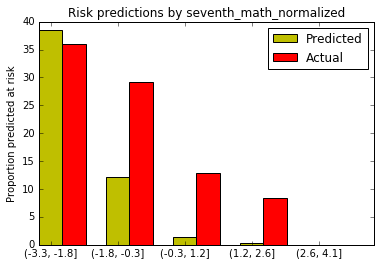

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time test


gpa_gr_7,"(0.5, 1.2]","(1.2, 1.9]","(1.9, 2.6]","(2.6, 3.3]","(3.3, 4]",All
predicted_label: True,81.82,26.76,8.29,0.00,0.75,4.17
predicted_label: False,18.18,73.24,91.71,100.00,99.25,95.83
true_label: True,81.82,46.48,38.67,18.56,6.98,18.72
true_label: False,18.18,53.52,61.33,81.44,93.02,81.28
true_label: All,0.98,6.30,16.06,29.64,47.03,100.00


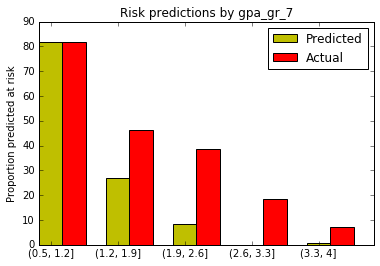

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time test


gpa_district_gr_7,"(-2.6, -1.8]","(-1.8, -1]","(-1, -0.2]","(-0.2, 0.6]","(0.6, 1.4]",All
predicted_label: True,66.67,39.06,6.51,0.00,0.94,4.17
predicted_label: False,33.33,60.94,93.49,100.00,99.06,95.83
true_label: True,83.33,53.12,36.74,15.38,6.81,18.72
true_label: False,16.67,46.87,63.26,84.62,93.19,81.28
true_label: All,0.53,5.68,19.08,36.91,37.80,100.00


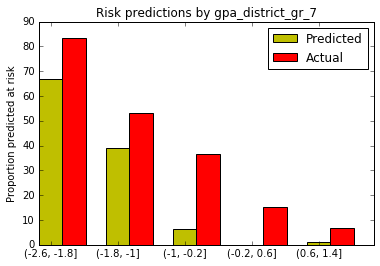

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time test


stem_gpa_gr_7,"(0.2, 1]","(1, 1.7]","(1.7, 2.5]","(2.5, 3.2]","(3.2, 4]",All
predicted_label: True,65.22,19.81,3.87,0.30,0.86,4.34
predicted_label: False,34.78,80.19,96.13,99.70,99.14,95.66
true_label: True,52.17,47.17,36.13,16.52,7.07,19.00
true_label: False,47.83,52.83,63.87,83.48,92.93,81.00
true_label: All,2.12,9.78,14.30,30.72,43.08,100.00


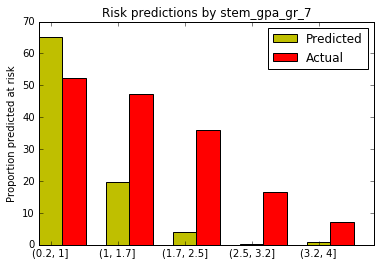

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time test


humanities_gpa_gr_7,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,41.18,21.05,9.48,1.01,0.81,4.27
predicted_label: False,58.82,78.95,90.52,98.99,99.19,95.73
true_label: True,70.59,50.88,33.18,17.45,7.69,18.66
true_label: False,29.41,49.12,66.82,82.55,92.31,81.34
true_label: All,1.58,5.29,19.59,27.67,45.87,100.00


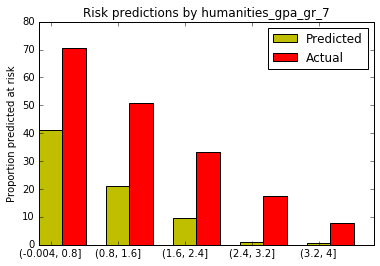

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time test


eighth_math_percentile,"(-0.0006, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,37.35,9.05,4.27,0.48,0.00,10.42
predicted_label: False,62.65,90.95,95.73,99.52,100.00,89.58
true_label: True,46.64,27.87,17.52,10.39,5.14,21.79
true_label: False,53.36,72.13,82.48,89.61,94.86,78.21
true_label: All,20.42,19.37,22.17,19.61,18.43,100.00


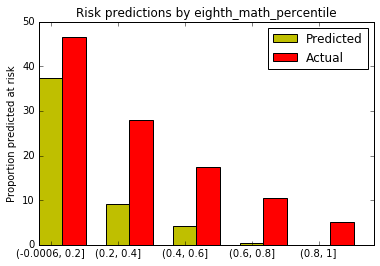

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time test


absence_gr_7,"(-0.08, 15.6]","(15.6, 31.2]","(31.2, 46.8]","(46.8, 62.4]","(62.4, 78]",All
predicted_label: True,17.34,8.05,50.00,0.00,0.00,16.81
predicted_label: False,82.66,91.95,50.00,100.00,100.00,83.19
true_label: True,21.07,40.27,66.67,0.00,100.00,22.44
true_label: False,78.93,59.73,33.33,100.00,0.00,77.56
true_label: All,93.25,6.41,0.26,0.04,0.04,100.00


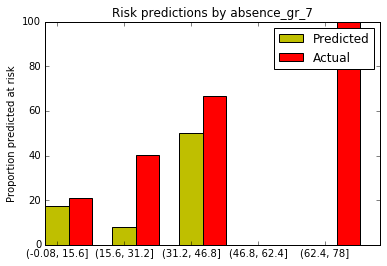

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time test


eighth_math_normalized,"(-3.4, -1.9]","(-1.9, -0.4]","(-0.4, 1.05]","(1.05, 2.5]","(2.5, 4]",All
predicted_label: True,54.79,24.96,2.85,0.00,0.00,10.42
predicted_label: False,45.21,75.04,97.15,100.00,100.00,89.58
true_label: True,45.21,41.37,14.27,6.07,0.00,21.79
true_label: False,54.79,58.63,85.73,93.93,100.00,78.21
true_label: All,3.46,27.71,56.42,11.70,0.71,100.00


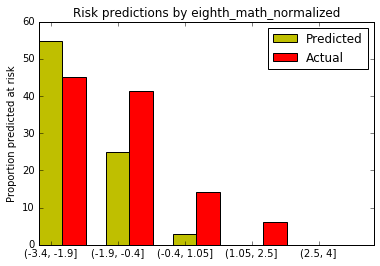

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time test


eighth_science_normalized,"(-3.3, -1.9]","(-1.9, -0.6]","(-0.6, 0.8]","(0.8, 2.1]","(2.1, 3.4]",All
predicted_label: True,53.70,28.69,4.26,1.00,0.00,10.42
predicted_label: False,46.30,71.31,95.74,99.00,100.00,89.58
true_label: True,64.81,42.42,16.38,9.04,3.12,21.79
true_label: False,35.19,57.58,83.62,90.96,96.88,78.21
true_label: All,2.56,23.45,48.89,23.59,1.52,100.00


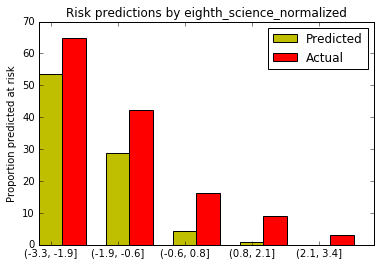

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time test


eighth_science_percentile,"(-0.0004, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,37.06,12.24,2.23,1.85,0.89,10.42
predicted_label: False,62.94,87.76,97.77,98.15,99.11,89.58
true_label: True,51.78,24.48,17.87,9.49,8.24,21.79
true_label: False,48.22,75.52,82.13,90.51,91.76,78.21
true_label: All,18.66,20.51,19.09,20.46,21.27,100.00


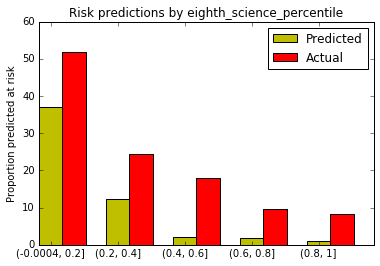

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time test


sixth_math_percentile,"(-1, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,29.60,9.33,2.53,0.74,0.00,8.08
predicted_label: False,70.40,90.67,97.47,99.26,100.00,91.92
true_label: True,45.87,27.20,15.40,13.65,4.76,20.82
true_label: False,54.13,72.80,84.60,86.35,95.24,79.18
true_label: All,19.05,19.05,20.11,20.47,21.33,100.00


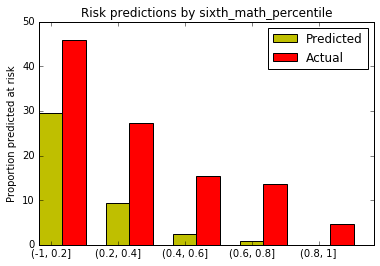

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time test


gpa_gr_8,"(0.5, 1.2]","(1.2, 1.9]","(1.9, 2.6]","(2.6, 3.3]","(3.3, 4]",All
predicted_label: True,88.46,58.59,12.60,1.55,2.49,10.02
predicted_label: False,11.54,41.41,87.40,98.45,97.51,89.98
true_label: True,65.38,48.48,35.43,15.25,7.30,19.20
true_label: False,34.62,51.52,64.57,84.75,92.70,80.80
true_label: All,1.96,7.45,19.13,29.14,42.32,100.00


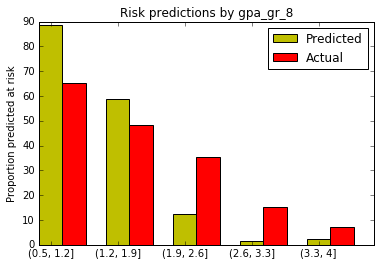

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time test


gpa_district_gr_8,"(-2.2, -1.4]","(-1.4, -0.7]","(-0.7, 0.02]","(0.02, 0.7]","(0.7, 1.5]",All
predicted_label: True,87.50,46.34,9.81,0.58,4.13,10.02
predicted_label: False,12.50,53.66,90.19,99.42,95.87,89.98
true_label: True,56.25,54.47,28.48,10.42,7.67,19.20
true_label: False,43.75,45.53,71.52,89.58,92.33,80.80
true_label: All,2.41,9.26,23.80,39.01,25.53,100.00


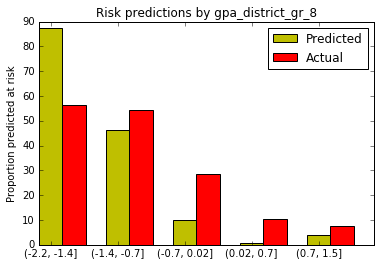

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time test


absence_gr_8,"(-0.2, 31.7]","(31.7, 63.4]","(63.4, 95.1]","(95.1, 126.8]","(126.8, 158.5]",All
predicted_label: True,14.81,34.29,NaN,NaN,0.00,15.05
predicted_label: False,85.19,65.71,NaN,NaN,100.00,84.95
true_label: True,23.98,60.00,NaN,NaN,100.00,24.47
true_label: False,76.02,40.00,NaN,NaN,0.00,75.53
true_label: All,98.67,1.30,0.0,0.0,0.04,100.00


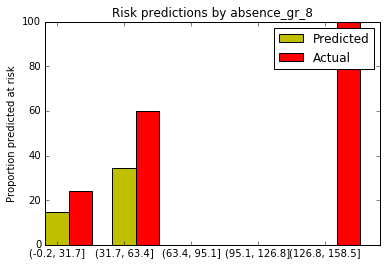

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time test


eighth_math_percentile,"(-0.0006, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,38.30,5.50,1.59,0.44,0.00,9.30
predicted_label: False,61.70,94.50,98.41,99.56,100.00,90.70
true_label: True,46.38,28.21,17.93,10.04,5.28,21.72
true_label: False,53.62,71.79,82.07,89.96,94.72,78.28
true_label: All,20.42,18.94,21.81,19.90,18.94,100.00


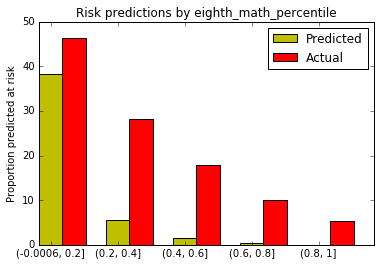

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time test


stem_gpa_gr_8,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,81.82,44.83,14.78,2.88,2.81,9.95
predicted_label: False,18.18,55.17,85.22,97.12,97.19,90.05
true_label: True,68.18,43.10,35.65,13.75,8.43,19.06
true_label: False,31.82,56.90,64.35,86.25,91.57,80.94
true_label: All,1.67,8.81,17.46,34.24,37.81,100.00


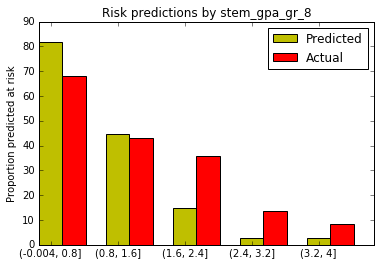

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time test


eighth_math_normalized,"(-3.4, -1.9]","(-1.9, -0.4]","(-0.4, 1.05]","(1.05, 2.5]","(2.5, 4]",All
predicted_label: True,59.49,23.34,1.47,0.00,0.00,9.30
predicted_label: False,40.51,76.66,98.53,100.00,100.00,90.70
true_label: True,45.57,41.64,14.21,5.73,0.00,21.72
true_label: False,54.43,58.36,85.79,94.27,100.00,78.28
true_label: All,3.43,27.54,56.26,12.12,0.65,100.00


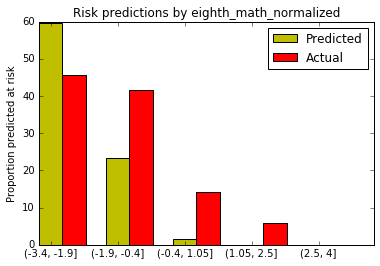

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time test


humanities_gpa_gr_8,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,81.48,44.58,17.90,3.64,2.26,9.95
predicted_label: False,18.52,55.42,82.10,96.36,97.74,90.05
true_label: True,51.85,43.37,36.19,18.79,7.26,18.98
true_label: False,48.15,56.63,63.81,81.21,92.74,81.02
true_label: All,2.05,6.30,19.51,25.06,47.08,100.00


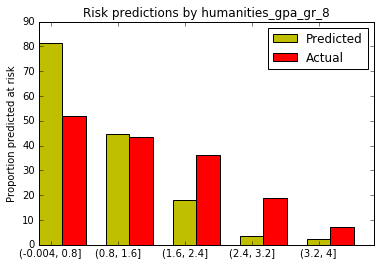

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time test


eighth_science_normalized,"(-3.3, -1.9]","(-1.9, -0.6]","(-0.6, 0.8]","(0.8, 2.1]","(2.1, 3.4]",All
predicted_label: True,63.16,26.47,2.48,0.19,0.00,9.30
predicted_label: False,36.84,73.53,97.52,99.81,100.00,90.70
true_label: True,64.91,41.56,16.06,9.00,3.03,21.72
true_label: False,35.09,58.44,83.94,91.00,96.97,78.28
true_label: All,2.48,24.46,48.96,22.68,1.43,100.00


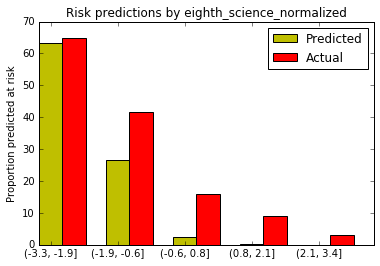

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time test


seventh_read_normalized,"(-3, -1.7]","(-1.7, -0.4]","(-0.4, 0.9]","(0.9, 2.2]","(2.2, 3.6]",All
predicted_label: True,54.84,16.48,2.84,0.49,0.00,9.11
predicted_label: False,45.16,83.52,97.16,99.51,100.00,90.89
true_label: True,46.77,37.28,14.08,7.16,5.88,21.09
true_label: False,53.23,62.72,85.92,92.84,94.12,78.91
true_label: All,5.56,28.04,47.47,18.17,0.76,100.00


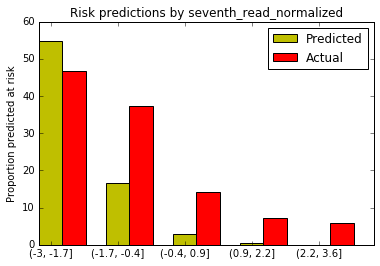

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time test


eighth_read_normalized,"(-3.002, -1.7]","(-1.7, -0.4]","(-0.4, 0.9]","(0.9, 2.3]","(2.3, 3.6]",All
predicted_label: True,65.83,17.92,1.60,0.00,0.00,9.30
predicted_label: False,34.17,82.08,98.40,100.00,100.00,90.70
true_label: True,52.50,38.74,13.64,8.13,2.70,21.73
true_label: False,47.50,61.26,86.36,91.87,97.30,78.27
true_label: All,5.22,28.38,48.76,16.04,1.61,100.00


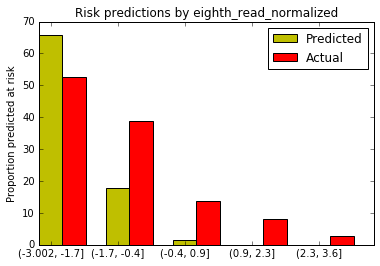

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time test


gpa_district_gr_9,"(-2.7, -1.9]","(-1.9, -1.1]","(-1.1, -0.3]","(-0.3, 0.5]","(0.5, 1.3]",All
predicted_label: True,72.22,33.10,7.67,2.20,1.72,6.79
predicted_label: False,27.78,66.90,92.33,97.80,98.28,93.21
true_label: True,52.78,44.37,23.93,10.77,5.50,15.35
true_label: False,47.22,55.63,76.07,89.23,94.50,84.65
true_label: All,1.82,7.19,22.44,39.06,29.48,100.00


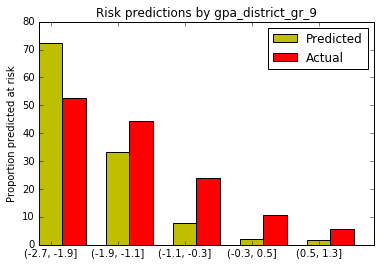

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time test


absence_gr_9,"(-0.08, 15.3]","(15.3, 30.6]","(30.6, 45.9]","(45.9, 61.2]","(61.2, 76.5]",All
predicted_label: True,6.69,17.85,32.50,0.00,40.0,8.87
predicted_label: False,93.31,82.15,67.50,100.00,60.0,91.13
true_label: True,14.26,36.48,52.50,33.33,40.0,18.35
true_label: False,85.74,63.52,47.50,66.67,60.0,81.65
true_label: All,82.78,15.30,1.61,0.12,0.2,100.00


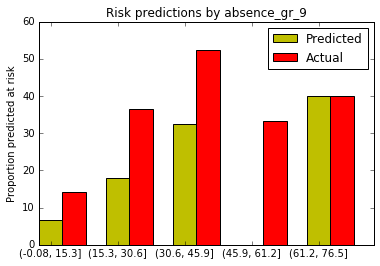

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time test


gpa_gr_9,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,64.44,27.27,7.73,2.24,1.31,6.79
predicted_label: False,35.56,72.73,92.27,97.76,98.69,93.21
true_label: True,55.56,36.93,24.09,10.72,5.81,15.35
true_label: False,44.44,63.07,75.91,89.28,94.19,84.65
true_label: All,2.28,8.92,22.29,31.66,34.85,100.00


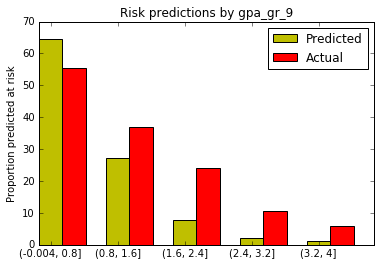

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time test


humanities_gpa_gr_9,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,56.25,13.59,9.56,1.02,1.21,6.45
predicted_label: False,43.75,86.41,90.44,98.98,98.79,93.55
true_label: True,48.75,31.55,21.45,10.37,6.34,15.08
true_label: False,51.25,68.45,78.55,89.63,93.66,84.92
true_label: All,4.16,10.71,20.12,30.58,34.43,100.00


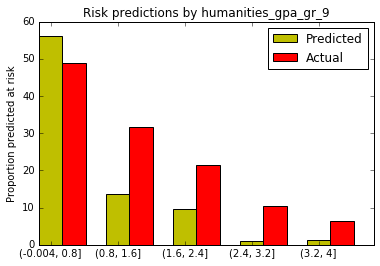

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time test


eighth_math_percentile,"(-0.0006, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,22.2,4.71,0.64,0.00,0.00,5.24
predicted_label: False,77.8,95.29,99.36,100.00,100.00,94.76
true_label: True,37.8,22.33,13.35,7.61,3.76,16.59
true_label: False,62.2,77.67,86.65,92.39,96.24,83.41
true_label: All,19.0,18.67,21.87,20.71,19.74,100.00


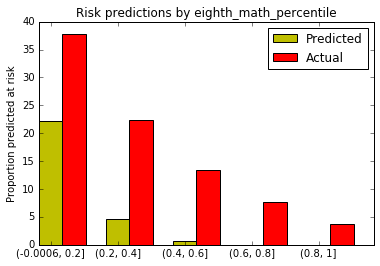

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time test


health_gpa_gr_9,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,47.37,21.17,9.68,5.50,1.23,6.74
predicted_label: False,52.63,78.83,90.32,94.50,98.77,93.26
true_label: True,49.12,37.96,23.66,14.04,6.05,14.86
true_label: False,50.88,62.04,76.34,85.96,93.95,85.14
true_label: All,3.15,7.57,15.41,29.12,44.75,100.00


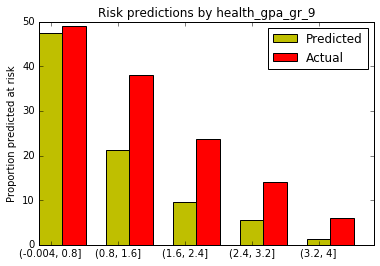

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time test


eighth_math_normalized,"(-3.4, -1.9]","(-1.9, -0.4]","(-0.4, 1.05]","(1.05, 2.5]","(2.5, 4]",All
predicted_label: True,36.51,14.11,0.81,0.00,0.0,5.24
predicted_label: False,63.49,85.89,99.19,100.00,100.0,94.76
true_label: True,33.33,33.86,10.66,4.73,0.0,16.59
true_label: False,66.67,66.14,89.34,95.27,100.0,83.41
true_label: All,2.92,26.27,57.37,12.74,0.7,100.00


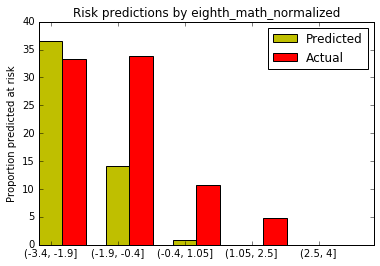

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time test


eighth_read_normalized,"(-3.002, -1.7]","(-1.7, -0.4]","(-0.4, 0.9]","(0.9, 2.3]","(2.3, 3.6]",All
predicted_label: True,39.00,11.17,0.83,0.00,0.00,5.24
predicted_label: False,61.00,88.83,99.17,100.00,100.00,94.76
true_label: True,43.00,30.93,10.38,6.13,2.70,16.60
true_label: False,57.00,69.07,89.62,93.87,97.30,83.40
true_label: All,4.64,26.98,50.02,16.64,1.72,100.00


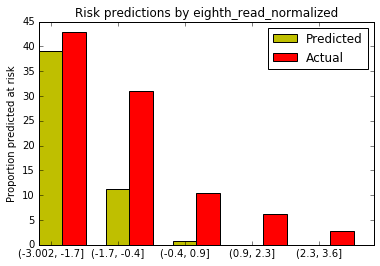

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time test


stem_gpa_gr_9,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,36.75,15.42,4.65,1.41,2.34,6.84
predicted_label: False,63.25,84.58,95.35,98.59,97.66,93.16
true_label: True,41.03,27.57,17.60,9.60,7.87,15.70
true_label: False,58.97,72.43,82.40,90.40,92.13,84.30
true_label: All,7.15,13.07,24.98,26.08,28.71,100.00


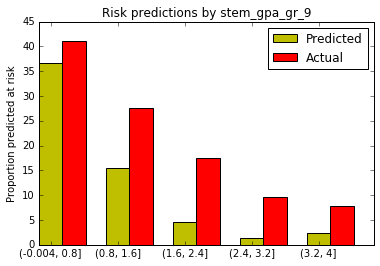

08_09_2016_grade_10_param_set_0_RF_ht_8680 RF not_on_time test


seventh_math_normalized,"(-2.8, -1.5]","(-1.5, -0.2]","(-0.2, 1.006]","(1.006, 2.3]","(2.3, 3.5]",All
predicted_label: True,33.04,8.67,0.91,0.00,0.00,4.98
predicted_label: False,66.96,91.33,99.09,100.00,100.00,95.02
true_label: True,39.29,27.06,10.10,4.95,2.78,16.27
true_label: False,60.71,72.94,89.90,95.05,97.22,83.73
true_label: All,5.36,32.01,47.37,13.54,1.72,100.00


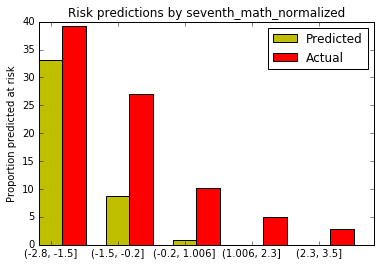

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time val


gpa_gr_7,"(0.5, 1.2]","(1.2, 1.9]","(1.9, 2.6]","(2.6, 3.3]","(3.3, 4]",All
predicted_label: True,91.30,28.95,3.87,0.71,0.28,5.75
predicted_label: False,8.70,71.05,96.13,99.29,99.72,94.25
true_label: True,82.61,43.42,33.15,12.72,9.19,19.63
true_label: False,17.39,56.58,66.85,87.28,90.81,80.37
true_label: All,2.49,8.24,19.63,30.69,38.94,100.00


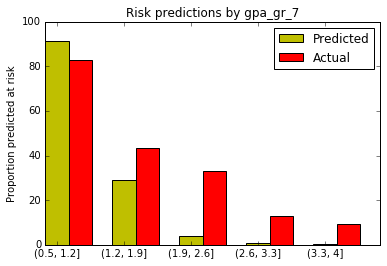

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time val


gpa_district_gr_7,"(-2.3, -1.5]","(-1.5, -0.8]","(-0.8, -0.1]","(-0.1, 0.6]","(0.6, 1.3]",All
predicted_label: True,91.30,28.24,2.63,0.86,0.00,5.75
predicted_label: False,8.70,71.76,97.37,99.14,100.00,94.25
true_label: True,78.26,47.06,31.05,12.36,7.61,19.63
true_label: False,21.74,52.94,68.95,87.64,92.39,80.37
true_label: All,2.49,9.22,20.61,37.74,29.93,100.00


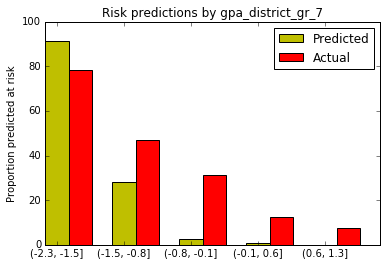

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time val


stem_gpa_gr_7,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,58.62,21.43,4.82,1.37,0.60,5.65
predicted_label: False,41.38,78.57,95.18,98.63,99.40,94.35
true_label: True,72.41,42.86,23.49,15.75,9.52,19.54
true_label: False,27.59,57.14,76.51,84.25,90.48,80.46
true_label: All,3.15,10.64,18.02,31.70,36.48,100.00


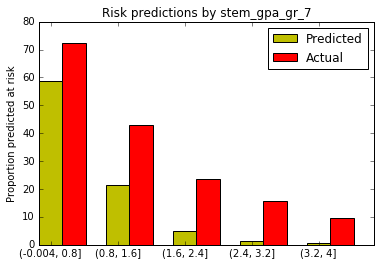

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time val


humanities_gpa_gr_7,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,77.27,22.78,6.63,1.43,0.29,5.77
predicted_label: False,22.73,77.22,93.37,98.57,99.71,94.23
true_label: True,72.73,49.37,30.61,11.83,9.36,19.61
true_label: False,27.27,50.63,69.39,88.17,90.64,80.39
true_label: All,2.40,8.61,21.35,30.39,37.25,100.00


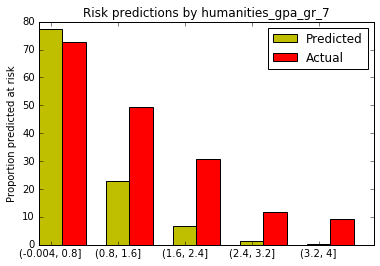

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time val


eighth_math_percentile,"(0.002, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,31.90,10.96,1.76,4.08,0.67,9.1
predicted_label: False,68.10,89.04,98.24,95.92,99.33,90.9
true_label: True,37.07,27.40,11.97,13.47,10.70,19.6
true_label: False,62.93,72.60,88.03,86.53,89.30,80.4
true_label: All,17.16,21.60,21.01,18.12,22.12,100.0


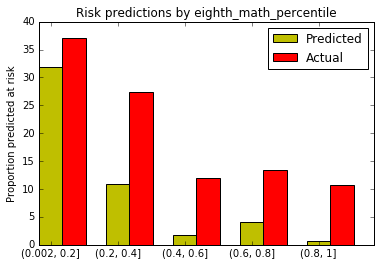

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time val


absence_gr_7,"(-0.09, 17.2]","(17.2, 34.4]","(34.4, 51.6]","(51.6, 68.8]","(68.8, 86]",All
predicted_label: True,9.00,21.55,33.33,0.00,100.00,10.19
predicted_label: False,91.00,78.45,66.67,100.00,0.00,89.81
true_label: True,18.78,46.55,66.67,0.00,100.00,21.31
true_label: False,81.22,53.45,33.33,100.00,0.00,78.69
true_label: All,91.09,8.27,0.43,0.14,0.07,100.00


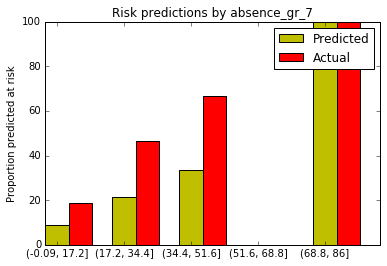

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time val


eighth_math_normalized,"(-2.5, -1.4]","(-1.4, -0.3]","(-0.3, 0.8]","(0.8, 1.9]","(1.9, 3.0006]",All
predicted_label: True,39.08,16.48,2.84,0.77,0.00,9.1
predicted_label: False,60.92,83.52,97.16,99.23,100.00,90.9
true_label: True,51.72,27.69,12.67,11.97,2.50,19.6
true_label: False,48.28,72.31,87.33,88.03,97.50,80.4
true_label: All,6.43,32.32,39.13,19.16,2.96,100.0


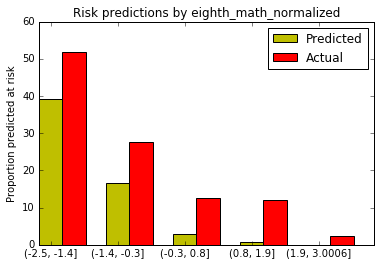

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time val


eighth_science_normalized,"(-2.6, -1.2]","(-1.2, 0.1]","(0.1, 1.5]","(1.5, 2.8]","(2.8, 4.1]",All
predicted_label: True,42.0,11.93,1.86,1.19,0.00,9.02
predicted_label: False,58.0,88.07,98.14,98.81,100.00,90.98
true_label: True,46.0,24.91,11.19,11.90,12.50,19.60
true_label: False,54.0,75.09,88.81,88.10,87.50,80.40
true_label: All,7.4,42.16,43.64,6.21,0.59,100.00


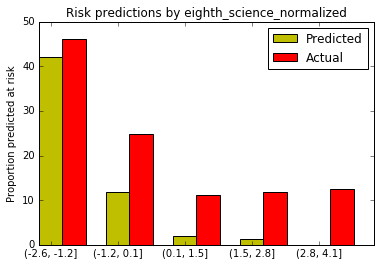

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time val


eighth_science_percentile,"(0.003, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,28.94,12.97,4.65,2.42,1.04,9.02
predicted_label: False,71.06,87.03,95.35,97.58,98.96,90.98
true_label: True,37.45,24.27,20.93,13.29,7.27,19.60
true_label: False,62.55,75.73,79.07,86.71,92.73,80.40
true_label: All,17.38,17.68,19.08,24.48,21.38,100.00


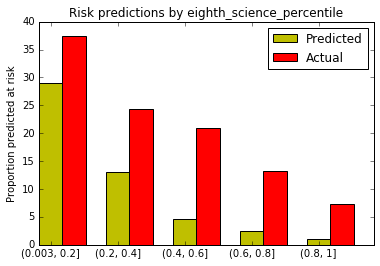

08_09_2016_grade_8_param_set_13_RF_ht_13254 RF not_on_time val


sixth_math_percentile,"(0.003, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,31.36,5.93,4.41,1.21,0.32,7.70
predicted_label: False,68.64,94.07,95.59,98.79,99.68,92.30
true_label: True,39.09,22.88,19.85,10.12,7.07,18.74
true_label: False,60.91,77.12,80.15,89.88,92.93,81.26
true_label: All,17.11,18.35,21.15,19.21,24.18,100.00


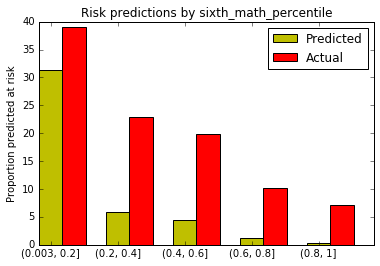

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time val


gpa_gr_8,"(0.2, 1]","(1, 1.7]","(1.7, 2.5]","(2.5, 3.2]","(3.2, 4]",All
predicted_label: True,100.00,64.81,10.10,0.76,0.63,6.55
predicted_label: False,0.00,35.19,89.90,99.24,99.37,93.45
true_label: True,69.23,50.00,38.94,16.16,9.28,19.65
true_label: False,30.77,50.00,61.06,83.84,90.72,80.35
true_label: All,1.14,4.72,18.17,34.59,41.40,100.00


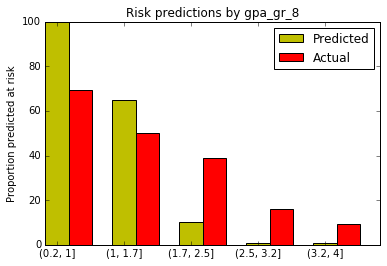

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time val


gpa_district_gr_8,"(-2.4, -1.7]","(-1.7, -0.9]","(-0.9, -0.1]","(-0.1, 0.6]","(0.6, 1.4]",All
predicted_label: True,100.0,49.35,6.37,0.46,0.82,6.55
predicted_label: False,0.0,50.65,93.63,99.54,99.18,93.45
true_label: True,75.0,48.05,33.07,13.99,8.77,19.65
true_label: False,25.0,51.95,66.93,86.01,91.23,80.35
true_label: All,1.4,6.72,21.92,38.08,31.88,100.00


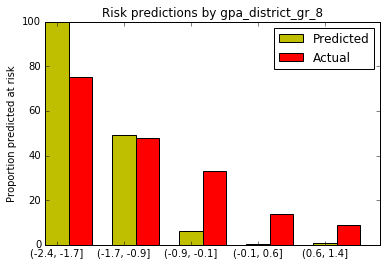

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time val


absence_gr_8,"(-0.05, 9.4]","(9.4, 18.8]","(18.8, 28.2]","(28.2, 37.6]","(37.6, 47]",All
predicted_label: True,19.35,7.39,23.53,34.62,75.00,17.83
predicted_label: False,80.65,92.61,76.47,65.38,25.00,82.17
true_label: True,25.13,22.17,44.12,61.54,75.00,25.88
true_label: False,74.87,77.83,55.88,38.46,25.00,74.12
true_label: All,78.58,16.16,4.06,1.04,0.16,100.00


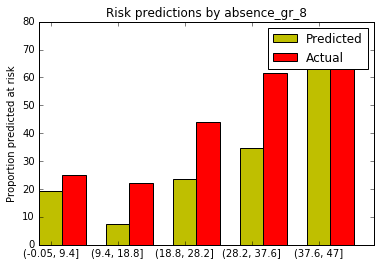

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time val


eighth_math_percentile,"(-0.0006, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,45.56,7.91,1.83,2.46,0.21,11.49
predicted_label: False,54.44,92.09,98.17,97.54,99.79,88.51
true_label: True,42.60,28.40,16.93,13.55,10.19,22.44
true_label: False,57.40,71.60,83.07,86.45,89.81,77.56
true_label: All,19.55,21.95,19.46,18.08,20.97,100.00


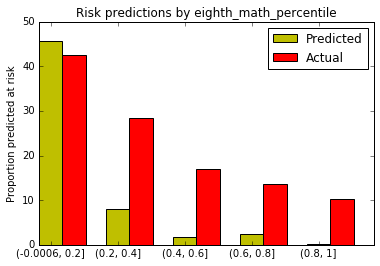

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time val


stem_gpa_gr_8,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,72.41,29.73,6.19,0.80,0.73,6.42
predicted_label: False,27.59,70.27,93.81,99.20,99.27,93.58
true_label: True,51.72,45.95,27.62,15.69,9.98,19.70
true_label: False,48.28,54.05,72.38,84.31,90.02,80.30
true_label: All,2.55,9.76,18.47,33.07,36.15,100.00


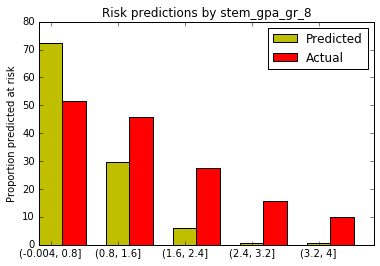

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time val


eighth_math_normalized,"(-3.6, -2.04]","(-2.04, -0.5]","(-0.5, 1.1]","(1.1, 2.7]","(2.7, 4.3]",All
predicted_label: True,75.00,29.35,2.13,0.00,0.00,11.49
predicted_label: False,25.00,70.65,97.87,100.00,100.00,88.51
true_label: True,67.86,37.27,15.32,10.66,16.67,22.44
true_label: False,32.14,62.73,84.68,89.34,83.33,77.56
true_label: All,1.25,32.01,54.36,12.11,0.27,100.00


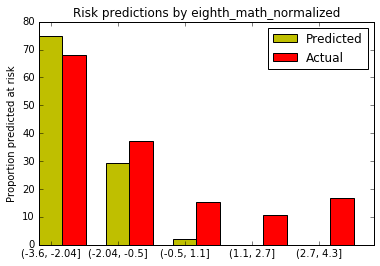

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time val


humanities_gpa_gr_8,"(-0.004, 0.8]","(0.8, 1.6]","(1.6, 2.4]","(2.4, 3.2]","(3.2, 4]",All
predicted_label: True,77.42,30.77,8.37,1.09,0.91,6.56
predicted_label: False,22.58,69.23,91.63,98.91,99.09,93.44
true_label: True,54.84,46.15,30.84,15.22,10.45,19.67
true_label: False,45.16,53.85,69.16,84.78,89.55,80.33
true_label: All,2.71,6.82,19.84,32.17,38.46,100.00


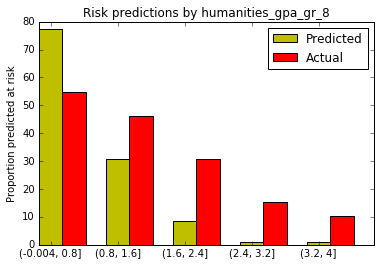

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time val


eighth_science_normalized,"(-3.2, -1.7]","(-1.7, -0.3]","(-0.3, 1.2]","(1.2, 2.7]","(2.7, 4.1]",All
predicted_label: True,65.12,22.63,1.94,0.44,0.00,11.49
predicted_label: False,34.88,77.37,98.06,99.56,100.00,88.51
true_label: True,56.98,34.26,15.00,5.75,10.00,22.44
true_label: False,43.02,65.74,85.00,94.25,90.00,77.56
true_label: All,3.83,35.22,50.45,10.06,0.45,100.00


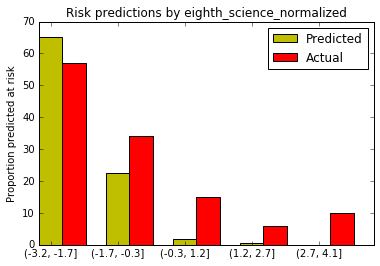

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time val


seventh_read_normalized,"(-3.4, -2.1]","(-2.1, -0.9]","(-0.9, 0.4]","(0.4, 1.7]","(1.7, 2.9]",All
predicted_label: True,76.00,33.94,7.99,1.36,0.00,11.53
predicted_label: False,24.00,66.06,92.01,98.64,100.00,88.47
true_label: True,60.00,41.25,21.49,10.87,8.79,21.73
true_label: False,40.00,58.75,78.51,89.13,91.21,78.27
true_label: All,2.29,17.52,42.36,33.67,4.16,100.00


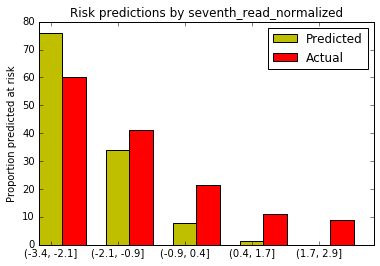

08_09_2016_grade_9_param_set_0_RF_ht_8645 RF not_on_time val


eighth_read_normalized,"(-3.7, -2.07]","(-2.07, -0.5]","(-0.5, 1.1]","(1.1, 2.7]","(2.7, 4.3]",All
predicted_label: True,72.41,26.64,3.08,0.44,0.00,11.48
predicted_label: False,27.59,73.36,96.92,99.56,100.00,88.52
true_label: True,55.17,37.14,16.02,8.77,0.00,22.43
true_label: False,44.83,62.86,83.98,91.23,100.00,77.57
true_label: All,2.58,29.24,57.77,10.15,0.27,100.00


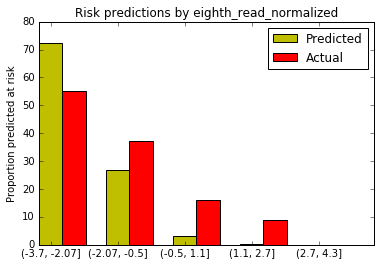

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time val


sixth_math_percentile,"(-0.0005, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,29.76,3.74,0.90,0.96,0.00,5.87
predicted_label: False,70.24,96.26,99.10,99.04,100.00,94.13
true_label: True,38.10,22.99,19.28,11.00,6.75,18.29
true_label: False,61.90,77.01,80.72,89.00,93.25,81.71
true_label: All,16.17,18.00,21.46,20.12,24.25,100.00


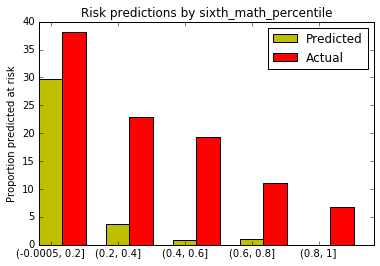

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time val


eighth_math_normalized,"(-2.5, -1.4]","(-1.4, -0.3]","(-0.3, 0.8]","(0.8, 1.9]","(1.9, 3.0006]",All
predicted_label: True,36.76,8.58,0.24,0.51,0.0,5.38
predicted_label: False,63.24,91.42,99.76,99.49,100.0,94.62
true_label: True,52.94,24.26,11.81,10.26,4.0,18.06
true_label: False,47.06,75.74,88.19,89.74,96.0,81.94
true_label: All,6.53,32.47,39.87,18.73,2.4,100.00


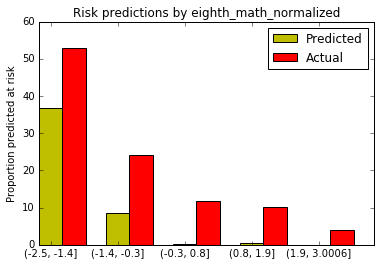

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time val


sixth_math_normalized,"(-7.05, -4.9]","(-4.9, -2.8]","(-2.8, -0.7]","(-0.7, 1.4]","(1.4, 3.5]",All
predicted_label: True,50.00,100.0,26.86,1.30,0.00,5.87
predicted_label: False,50.00,0.0,73.14,98.70,100.00,94.13
true_label: True,0.00,0.0,38.29,15.25,6.67,18.29
true_label: False,100.00,100.0,61.71,84.75,93.33,81.71
true_label: All,0.58,0.1,16.84,73.82,8.66,100.00


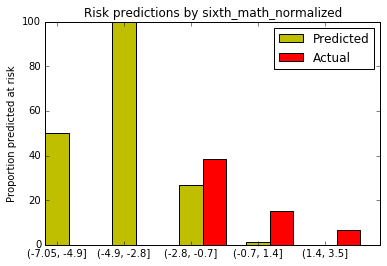

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time val


eighth_math_percentile,"(0.002, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,25.41,3.56,0.44,0.00,0.45,5.38
predicted_label: False,74.59,96.44,99.56,100.00,99.55,94.62
true_label: True,36.46,23.11,12.39,11.11,9.55,18.06
true_label: False,63.54,76.89,87.61,88.89,90.45,81.94
true_label: All,17.39,21.61,21.71,18.16,21.13,100.00


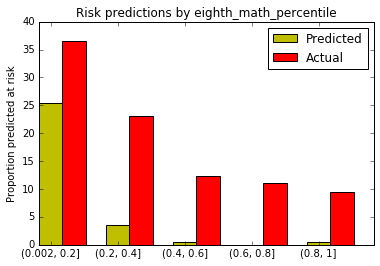

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time val


fifth_socstudies_normalized,"(-3.2, -1.9]","(-1.9, -0.6]","(-0.6, 0.7]","(0.7, 2]","(2, 3.3]",All
predicted_label: True,29.41,18.43,1.96,0.00,0.00,5.42
predicted_label: False,70.59,81.57,98.04,100.00,100.00,94.58
true_label: True,35.29,29.95,17.68,7.60,4.55,17.83
true_label: False,64.71,70.05,82.32,92.40,95.45,82.17
true_label: All,1.67,21.38,50.15,24.63,2.17,100.00


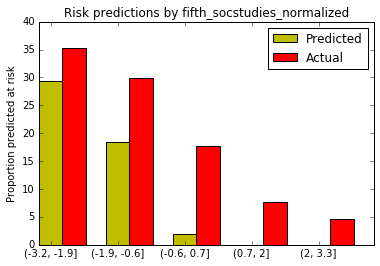

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time val


eighth_science_normalized,"(-2.6, -1.4]","(-1.4, -0.2]","(-0.2, 1.002]","(1.002, 2.2]","(2.2, 3.4]",All
predicted_label: True,42.86,8.29,0.00,0.00,0.00,5.12
predicted_label: False,57.14,91.71,100.00,100.00,100.00,94.88
true_label: True,42.86,27.14,13.38,4.82,9.09,18.16
true_label: False,57.14,72.86,86.62,95.18,90.91,81.84
true_label: All,5.41,33.82,42.61,16.04,2.13,100.00


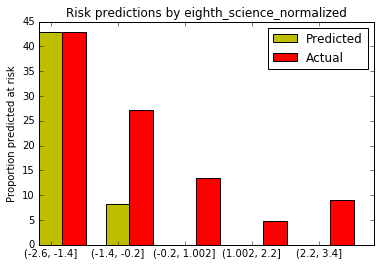

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time val


eighth_science_percentile,"(0.003, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,25.26,2.89,0.00,0.00,0.00,5.12
predicted_label: False,74.74,97.11,100.00,100.00,100.00,94.88
true_label: True,35.79,24.28,17.35,12.84,5.02,18.16
true_label: False,64.21,75.72,82.65,87.16,94.98,81.84
true_label: All,18.36,16.71,18.94,24.83,21.16,100.00


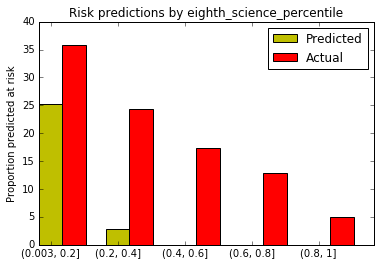

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time val


absence_gr_5,"(-0.04, 7.7]","(7.7, 15.4]","(15.4, 23.1]","(23.1, 30.8]","(30.8, 38.5]",All
predicted_label: True,6.06,5.88,17.65,20.00,0.00,6.86
predicted_label: False,93.94,94.12,82.35,80.00,100.00,93.14
true_label: True,15.09,25.61,30.88,50.00,100.00,19.39
true_label: False,84.91,74.39,69.12,50.00,0.00,80.61
true_label: All,65.77,26.81,6.31,0.93,0.19,100.00


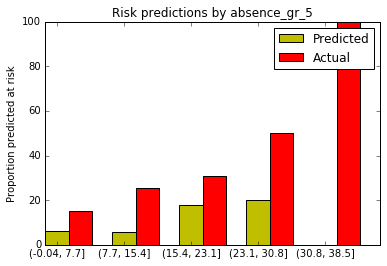

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time val


sixth_read_normalized,"(-7.4, -5.2]","(-5.2, -2.9]","(-2.9, -0.7]","(-0.7, 1.6]","(1.6, 3.8]",All
predicted_label: True,50.00,0.0,21.20,1.57,0.00,5.85
predicted_label: False,50.00,100.0,78.80,98.43,100.00,94.15
true_label: True,0.00,0.0,31.80,15.47,7.14,18.31
true_label: False,100.00,100.0,68.20,84.53,92.86,81.69
true_label: All,0.58,0.1,20.81,73.15,5.37,100.00


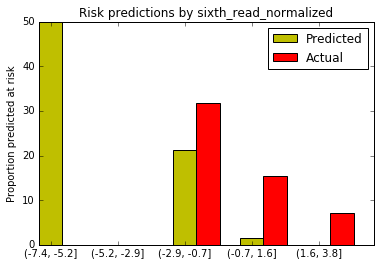

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time val


seventh_read_percentile,"(0.003, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,25.88,5.62,0.40,0.00,0.48,5.39
predicted_label: False,74.12,94.38,99.60,100.00,99.52,94.61
true_label: True,37.65,23.60,13.65,13.85,9.05,18.40
true_label: False,62.35,76.40,86.35,86.15,90.95,81.60
true_label: All,16.38,17.15,23.99,22.25,20.23,100.00


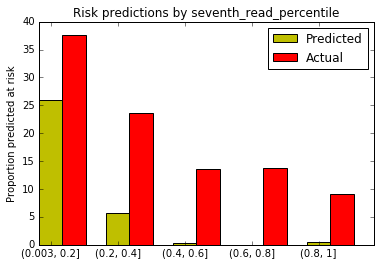

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time test


sixth_math_percentile,"(-1, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,30.56,5.29,2.91,0.51,0.00,6.26
predicted_label: False,69.44,94.71,97.09,99.49,100.00,93.74
true_label: True,42.36,29.63,16.50,12.76,4.58,19.18
true_label: False,57.64,70.37,83.50,87.24,95.42,80.82
true_label: All,14.77,19.38,21.13,20.10,24.62,100.00


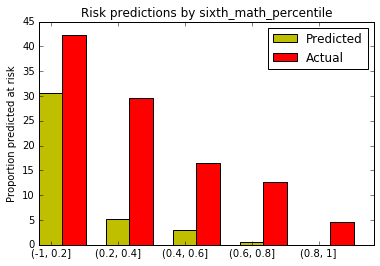

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time test


eighth_math_normalized,"(-3.008, -1.6]","(-1.6, -0.2]","(-0.2, 1.2]","(1.2, 2.6]","(2.6, 4]",All
predicted_label: True,45.71,11.82,0.19,0.00,0.00,5.50
predicted_label: False,54.29,88.18,99.81,100.00,100.00,94.50
true_label: True,37.14,33.55,12.57,2.73,0.00,18.96
true_label: False,62.86,66.45,87.43,97.27,100.00,81.04
true_label: All,3.57,31.91,52.70,11.21,0.61,100.00


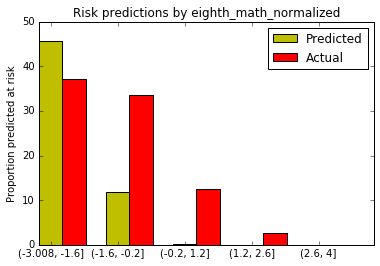

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time test


sixth_math_normalized,"(-2.9, -1.6]","(-1.6, -0.3]","(-0.3, 0.9]","(0.9, 2.2]","(2.2, 3.5]",All
predicted_label: True,61.29,12.82,1.50,0.00,0.00,6.26
predicted_label: False,38.71,87.18,98.50,100.00,100.00,93.74
true_label: True,61.29,33.70,14.81,2.84,6.90,19.18
true_label: False,38.71,66.30,85.19,97.16,93.10,80.82
true_label: All,3.18,28.00,47.79,18.05,2.97,100.00


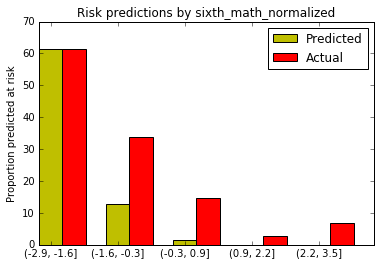

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time test


eighth_math_percentile,"(0.0003, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,29.94,3.14,0.45,0.00,0.00,5.50
predicted_label: False,70.06,96.86,99.55,100.00,100.00,94.50
true_label: True,44.59,25.13,20.09,7.58,3.54,18.96
true_label: False,55.41,74.87,79.91,92.42,96.46,81.04
true_label: All,16.00,19.47,22.83,21.51,20.18,100.00


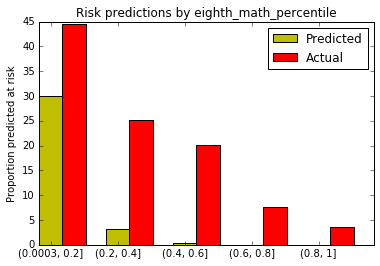

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time test


fifth_socstudies_normalized,"(-2.8, -1.3]","(-1.3, 0.2]","(0.2, 1.7]","(1.7, 3.2]","(3.2, 4.7]",All
predicted_label: True,33.80,8.29,0.45,1.61,0.00,6.12
predicted_label: False,66.20,91.71,99.55,98.39,100.00,93.88
true_label: True,42.25,28.50,9.71,8.06,0.00,19.50
true_label: False,57.75,71.50,90.29,91.94,100.00,80.50
true_label: All,7.37,40.04,45.95,6.43,0.21,100.00


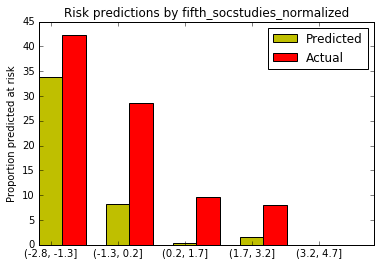

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time test


eighth_science_normalized,"(-2.7, -1.5]","(-1.5, -0.3]","(-0.3, 1]","(1, 2.2]","(2.2, 3.4]",All
predicted_label: True,37.74,10.66,1.13,0.00,0.00,5.50
predicted_label: False,62.26,89.34,98.87,100.00,100.00,94.50
true_label: True,52.83,33.82,11.94,5.73,10.00,18.96
true_label: False,47.17,66.18,88.06,94.27,90.00,81.04
true_label: All,5.40,27.73,45.26,19.57,2.04,100.00


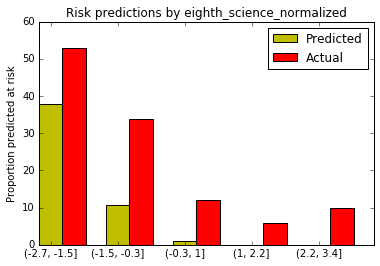

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time test


eighth_science_percentile,"(0.001, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,25.85,6.18,2.07,0.46,0.00,5.50
predicted_label: False,74.15,93.82,97.93,99.54,100.00,94.50
true_label: True,51.70,24.72,18.13,6.85,6.56,18.96
true_label: False,48.30,75.28,81.87,93.15,93.44,81.04
true_label: All,14.98,18.14,19.67,22.32,24.87,100.00


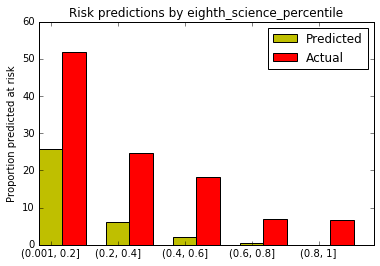

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time test


absence_gr_5,"(-0.04, 8.3]","(8.3, 16.6]","(16.6, 24.9]","(24.9, 33.2]","(33.2, 41.5]",All
predicted_label: True,14.64,14.61,18.75,16.67,33.33,14.93
predicted_label: False,85.36,85.39,81.25,83.33,66.67,85.07
true_label: True,16.23,23.38,25.00,16.67,66.67,18.78
true_label: False,83.77,76.62,75.00,83.33,33.33,81.22
true_label: All,66.20,26.90,5.59,1.05,0.26,100.00


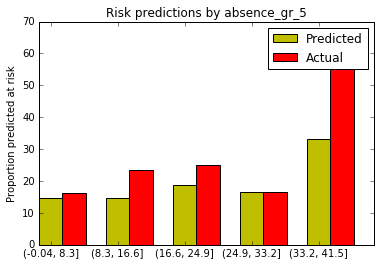

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time test


sixth_read_normalized,"(-3.2, -1.7]","(-1.7, -0.2]","(-0.2, 1.3]","(1.3, 2.8]","(2.8, 4.2]",All
predicted_label: True,45.45,13.74,0.77,0.00,0.00,6.35
predicted_label: False,54.55,86.26,99.23,100.00,100.00,93.65
true_label: True,51.52,32.91,11.52,7.62,0.00,19.24
true_label: False,48.48,67.09,88.48,92.38,100.00,80.76
true_label: All,3.38,32.04,53.33,10.75,0.51,100.00


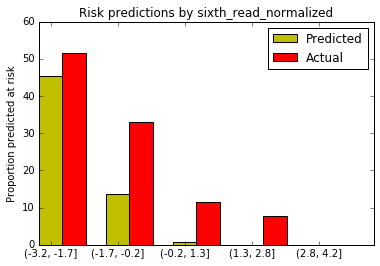

08_09_2016_grade_6_param_set_0_RF_ht_8585 RF not_on_time test


seventh_read_percentile,"(0.002, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]",All
predicted_label: True,30.62,3.95,0.43,0.47,0.00,5.91
predicted_label: False,69.38,96.05,99.57,99.53,100.00,94.09
true_label: True,46.87,25.99,14.66,7.48,6.57,18.76
true_label: False,53.12,74.01,85.34,92.52,93.43,81.24
true_label: All,16.31,18.04,23.65,21.81,20.18,100.00


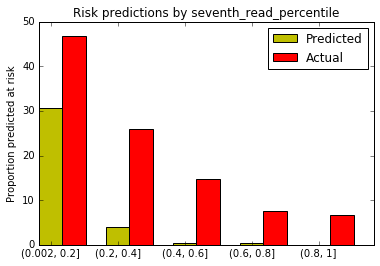

In [68]:
crosstab_to_plot = None
for model in all_top_crosstabs.keys():
    filename = model[0]
    model_name = model[1]
    outcome = model[2]
    split = model[3]
    
    if (model_name in ignore_models or split in ignore_splits or
        outcome in ignore_outcomes):
        continue
        
    else:
        if (filename in specific_feature_list):
            feature_list = specific_feature_list[filename]
        else:
            feature_list = all_top_crosstabs[model].keys()
        
        # Two subplots, the axes array is 1-d
        
        for i, feature in enumerate(feature_list):
            try:
                print(filename, model_name, outcome, split)
                crosstab_to_plot = get_specific_cross_tabs(
                    all_top_crosstabs, model, feature)
                crosstab_to_plot
                plt.figure()
                plot_crosstabs(crosstab_to_plot)
                plt.show()
            except KeyError:
                print('{} not in {}'.format(feature, filename))
                continue
        #plt.savefig(os.path.join(figpath, filename))

In [44]:
figpath = os.path.join(base_pathname, 'Error_Feature_Analysis', 'figs')

In [67]:
def plot_crosstabs(crosstab_to_plot):
    predicted_true = crosstab_to_plot.ix[0][0:-1]
    actual_true = crosstab_to_plot.ix[2][0:-1]
    ind = np.arange(len(predicted_true))
    width = 0.35
    
    p1 = plt.bar(ind, predicted_true, width, color='y')
    p2 = plt.bar(ind+width, actual_true, width, color='r')
    plt.ylabel('Proportion predicted at risk')
    plt.title('Risk predictions by ' + crosstab_to_plot.columns.name)
    plt.xticks(ind + width/2., list(crosstab_to_plot.columns[0:-1]))
    plt.legend((p1[0], p2[0]), ('Predicted', 'Actual'))
    return None

In [15]:
%load_ext rpy2.ipython

In [16]:
%Rpush crosstab_to_plot